# Panel and hierarchical forecasting

## Agenda:

1. Introduction
2. Forecasting with panel data
    * Data structure for panel timeseries
    * Local forecasting
    * Global forecasting
    * Quick review of literature about Global Forecasting
3. Forecasting with hierarchical data
    * Data structure for Hierarchical forecasting
    * Reconciliation methods

## Introduction

In the last lectures, we saw how we can straighfowardly obtain forecasts with sktime for individual timeseries. Now, we will see some concepts related to panel and hierarchical timeseries.

* **Panel series**:
<div align="center">
    <img src="imgs/example_stock_prices.png" alt="Example of stock prices" style="width:400px;">
</div>


* **Hierarchical series**:
    * Refers to panel that also have an hierarchical structure = **aggregation constraints**.

<div align="center">
    <img src="imgs/hierarchical_data_tree.png" alt="Example of hierarchical data" style="width:400px;">
</div>

## Forecasting with panel data

We will first go through panel forecasting, and then show some specific methods that can be applied to hierarchical forecasting problems

### Data structure for panel timeseries

* To handle timeseries datasets with multiple entities, sktime leverages pandas' multiindexes. Let's take a look at one example of panel data.
* This is a dataset from a famous competition, called M5

In [1]:
import warnings

warnings.filterwarnings("ignore")

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
from sktime.datasets import load_m5

data = load_m5("./data")
data = data[["sales"]]

In [3]:

y = data.reset_index()
y = y.groupby(["store_id", "cat_id", "date"])[["sales"]].sum()
y = y.reset_index()
y["store_category"] = y["store_id"].astype(str) + "-" + y["cat_id"].astype(str)
y = y.groupby(["store_category", "date"])[["sales"]].sum()
y

sales
store_category date             
CA_1-FOODS     2011-01-29   3239
               2011-01-30   3137
               2011-01-31   2008
               2011-02-01   2258
               2011-02-02   2032
...                          ...
WI_3-HOUSEHOLD 2016-04-20    683
               2016-04-21    715
               2016-04-22    867
               2016-04-23   1033
               2016-04-24    967

[57390 rows x 1 columns]

I would like you to take a look at the index structure of the dataframe `y`. It has two levels: `store_category` and `date`. The last level (right-most one) is always reserved to the time unit. The other level, at index 0, contains the name of each of the series. Sktime does not care about the names, just the order of the indexes.

(<Figure size 1600x400 with 1 Axes>, <Axes: ylabel='sales'>)

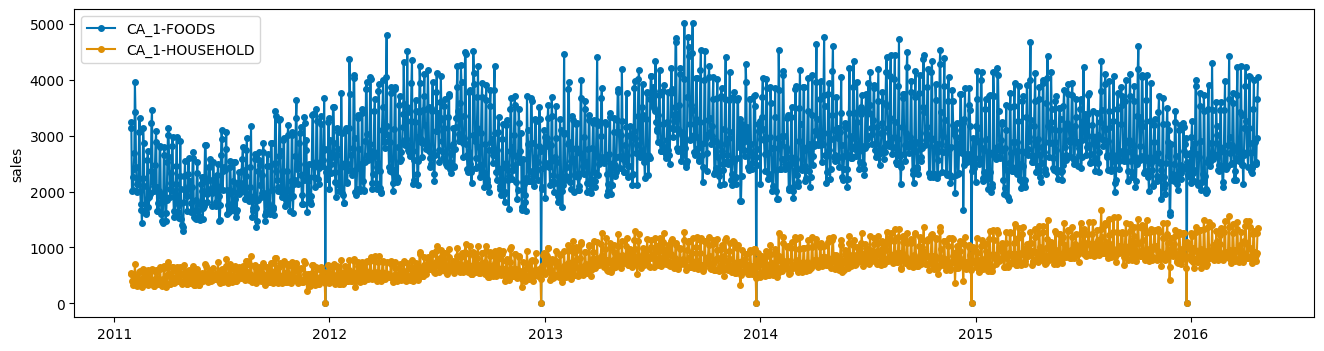

In [4]:
from sktime.utils.plotting import plot_series

plot_series(
    y.loc["CA_1-FOODS"],
    y.loc["CA_1-HOUSEHOLD"],
    labels=[
        "CA_1-FOODS",
        "CA_1-HOUSEHOLD",
    ]
)

Note that `y.index` is an instance of Multiindex:

In [5]:
y.index

MultiIndex([(    'CA_1-FOODS', '2011-01-29'),
            (    'CA_1-FOODS', '2011-01-30'),
            (    'CA_1-FOODS', '2011-01-31'),
            (    'CA_1-FOODS', '2011-02-01'),
            (    'CA_1-FOODS', '2011-02-02'),
            (    'CA_1-FOODS', '2011-02-03'),
            (    'CA_1-FOODS', '2011-02-04'),
            (    'CA_1-FOODS', '2011-02-05'),
            (    'CA_1-FOODS', '2011-02-06'),
            (    'CA_1-FOODS', '2011-02-07'),
            ...
            ('WI_3-HOUSEHOLD', '2016-04-15'),
            ('WI_3-HOUSEHOLD', '2016-04-16'),
            ('WI_3-HOUSEHOLD', '2016-04-17'),
            ('WI_3-HOUSEHOLD', '2016-04-18'),
            ('WI_3-HOUSEHOLD', '2016-04-19'),
            ('WI_3-HOUSEHOLD', '2016-04-20'),
            ('WI_3-HOUSEHOLD', '2016-04-21'),
            ('WI_3-HOUSEHOLD', '2016-04-22'),
            ('WI_3-HOUSEHOLD', '2016-04-23'),
            ('WI_3-HOUSEHOLD', '2016-04-24')],
           names=['store_category', 'date'], length=57390)

#### Review of multiindex operations


To get the number of levels, we can do:

In [6]:
y.index.nlevels

2

To obtain the values of just one level, `.get_level_values()` can be used:

In [7]:
y.index.get_level_values(0)

Index(['CA_1-FOODS', 'CA_1-FOODS', 'CA_1-FOODS', 'CA_1-FOODS', 'CA_1-FOODS',
       'CA_1-FOODS', 'CA_1-FOODS', 'CA_1-FOODS', 'CA_1-FOODS', 'CA_1-FOODS',
       ...
       'WI_3-HOUSEHOLD', 'WI_3-HOUSEHOLD', 'WI_3-HOUSEHOLD', 'WI_3-HOUSEHOLD',
       'WI_3-HOUSEHOLD', 'WI_3-HOUSEHOLD', 'WI_3-HOUSEHOLD', 'WI_3-HOUSEHOLD',
       'WI_3-HOUSEHOLD', 'WI_3-HOUSEHOLD'],
      dtype='object', name='store_category', length=57390)

In [8]:
y.index.get_level_values(1)

PeriodIndex(['2011-01-29', '2011-01-30', '2011-01-31', '2011-02-01',
             '2011-02-02', '2011-02-03', '2011-02-04', '2011-02-05',
             '2011-02-06', '2011-02-07',
             ...
             '2016-04-15', '2016-04-16', '2016-04-17', '2016-04-18',
             '2016-04-19', '2016-04-20', '2016-04-21', '2016-04-22',
             '2016-04-23', '2016-04-24'],
            dtype='period[D]', name='date', length=57390)

In [9]:
y.index.droplevel(1)

Index(['CA_1-FOODS', 'CA_1-FOODS', 'CA_1-FOODS', 'CA_1-FOODS', 'CA_1-FOODS',
       'CA_1-FOODS', 'CA_1-FOODS', 'CA_1-FOODS', 'CA_1-FOODS', 'CA_1-FOODS',
       ...
       'WI_3-HOUSEHOLD', 'WI_3-HOUSEHOLD', 'WI_3-HOUSEHOLD', 'WI_3-HOUSEHOLD',
       'WI_3-HOUSEHOLD', 'WI_3-HOUSEHOLD', 'WI_3-HOUSEHOLD', 'WI_3-HOUSEHOLD',
       'WI_3-HOUSEHOLD', 'WI_3-HOUSEHOLD'],
      dtype='object', name='store_category', length=57390)

When we retrieve the values of an index, it is an instance of the well-known `pd.Index`, and we can apply the standard operations on it, such as `.unique`:

In [10]:
y.index.get_level_values(0).unique()

Index(['CA_1-FOODS', 'CA_1-HOBBIES', 'CA_1-HOUSEHOLD', 'CA_2-FOODS',
       'CA_2-HOBBIES', 'CA_2-HOUSEHOLD', 'CA_3-FOODS', 'CA_3-HOBBIES',
       'CA_3-HOUSEHOLD', 'CA_4-FOODS', 'CA_4-HOBBIES', 'CA_4-HOUSEHOLD',
       'TX_1-FOODS', 'TX_1-HOBBIES', 'TX_1-HOUSEHOLD', 'TX_2-FOODS',
       'TX_2-HOBBIES', 'TX_2-HOUSEHOLD', 'TX_3-FOODS', 'TX_3-HOBBIES',
       'TX_3-HOUSEHOLD', 'WI_1-FOODS', 'WI_1-HOBBIES', 'WI_1-HOUSEHOLD',
       'WI_2-FOODS', 'WI_2-HOBBIES', 'WI_2-HOUSEHOLD', 'WI_3-FOODS',
       'WI_3-HOBBIES', 'WI_3-HOUSEHOLD'],
      dtype='object', name='store_category')

In [11]:
y.index.get_level_values(-1).min(), y.index.get_level_values(-1).max()

(Period('2011-01-29', 'D'), Period('2016-04-24', 'D'))

##### Selecting rows

To select specific lines of multiindex code, we can create a mask and filter the dataframe, use `.loc` directly or use it together with `pd.IndexSlice` for more advanced indexing:

In [12]:
mask = y.index.get_level_values(0) == "CA_1-FOODS"
y.loc[mask].tail()

sales
store_category date             
CA_1-FOODS     2016-04-20   2490
               2016-04-21   2533
               2016-04-22   2960
               2016-04-23   3655
               2016-04-24   4053

In [13]:
# This one removes the single index
y.loc["CA_1-FOODS"].tail()

,sales
date,
2016-04-20,2490
2016-04-21,2533
2016-04-22,2960
2016-04-23,3655
2016-04-24,4053


In [14]:
# Using a list, we can keep the multiindex
y.loc[["CA_1-FOODS"]].tail()

sales
store_category date             
CA_1-FOODS     2016-04-20   2490
               2016-04-21   2533
               2016-04-22   2960
               2016-04-23   3655
               2016-04-24   4053

In [15]:
# We can use a list of tuples to select multiple values
y.loc[[("CA_1-FOODS", "2016-04-20"), ("CA_1-FOODS", "2016-04-21")]]

sales
store_category date             
CA_1-FOODS     2016-04-20   2490
               2016-04-21   2533

In [16]:
# pd.IndexSlice works as .loc works for simple index
y.loc[pd.IndexSlice["CA_1-FOODS", "2016-04-20":],]

sales
store_category date             
CA_1-FOODS     2016-04-20   2490
               2016-04-21   2533
               2016-04-22   2960
               2016-04-23   3655
               2016-04-24   4053

### Forecasting strategies for panel data

* Two strategies: **broadcasting local forecasters** and **global forecasters**.
* We can also leverage the information contained in all of them to create a __global__ forecaster, with the hope that it can improve our accuracy. 
* Global forecasters can forecast every timeseries with the same set of parameters. 

<!-- We will first learn how to use sktime's API to forecast all timeseries with individual forecasters. Then, we will use reduction strategies to obtain global forecasters, and revisit some research that indicate that this might be the winning approach in certain scenarious. -->


In [17]:
# Splitting the data
from sktime.forecasting.model_selection import temporal_train_test_split

y_train, y_test = temporal_train_test_split(y, test_size=28)

In [18]:
y_test

sales
store_category date             
CA_1-FOODS     2016-03-28   2480
               2016-03-29   2481
               2016-03-30   2135
               2016-03-31   2651
               2016-04-01   3132
...                          ...
WI_3-HOUSEHOLD 2016-04-20    683
               2016-04-21    715
               2016-04-22    867
               2016-04-23   1033
               2016-04-24    967

[840 rows x 1 columns]

### Local strategy: individual forecasters for each series

* Sktime has a powerfull feature that allows you to use forecasters in panel data in the same way you use them to single series. 
* You shouldn't worry about it!

In [19]:
from sktime.forecasting.exp_smoothing import ExponentialSmoothing
import numpy as np
# Forecast horizon
fh = np.arange(1, 29)

# Fit and predict
model = ExponentialSmoothing(trend="add", seasonal="add")
model.fit(y_train)


/Users/felipeangelim/Workspace/forecasting-course/.venv/lib/python3.11/site-packages/statsmodels/tsa/holtwinters/model.py:918: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
/Users/felipeangelim/Workspace/forecasting-course/.venv/lib/python3.11/site-packages/statsmodels/tsa/holtwinters/model.py:918: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
/Users/felipeangelim/Workspace/forecasting-course/.venv/lib/python3.11/site-packages/statsmodels/tsa/holtwinters/model.py:918: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
/Users/felipeangelim/Workspace/forecasting-course/.venv/lib/python3.11/site-packages/statsmodels/tsa/holtwinters/model.py:918: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
/Users/felipeangelim/Workspace/forecasting-course/.venv/lib/python3.11/site-packages/statsmodels/tsa/holtwinters/model.py:918: Convergen

ExponentialSmoothing(seasonal='add', trend='add')

In [20]:
y_pred = model.predict(fh=fh)
y_pred

sales
store_category date                   
CA_1-FOODS     2016-03-28  2911.356084
               2016-03-29  2624.355798
               2016-03-30  2572.872492
               2016-03-31  2532.407838
               2016-04-01  2827.877568
...                                ...
WI_3-HOUSEHOLD 2016-04-20   630.128780
               2016-04-21   666.940242
               2016-04-22   802.788946
               2016-04-23   976.947600
               2016-04-24   894.354946

[840 rows x 1 columns]

(<Figure size 1600x400 with 1 Axes>, <Axes: ylabel='sales'>)

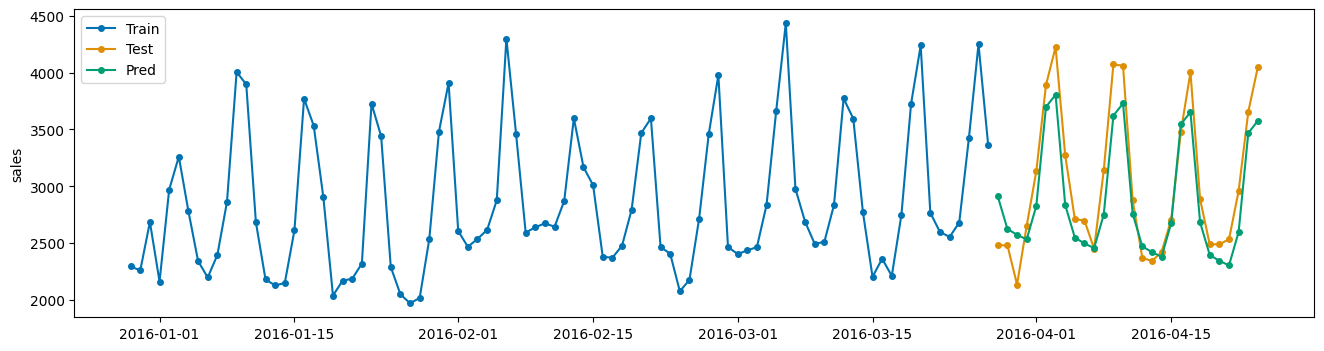

In [21]:
from sktime.utils.plotting import plot_series

selected_series = "CA_1-FOODS"
plot_series(
    y_train.loc[selected_series].iloc[-90:],
    y_test.loc[selected_series],
    y_pred.loc[selected_series],
    labels=["Train", "Test", "Pred"],
)

Note that no extra code was needed to forecast this panel timeseries. Internally, when we call `fit` of a forecaster and pass a multiindex pandas related to panel dataset, many replicas of the forecaster are created, so that we have one forecaster for each series. You can access these internal forecasters too:

In [22]:
fitted_params = model.get_fitted_params()
fitted_params["forecasters"]

,forecasters
CA_1-FOODS,"ExponentialSmoothing(seasonal='add', trend='add')"
CA_1-HOBBIES,"ExponentialSmoothing(seasonal='add', trend='add')"
CA_1-HOUSEHOLD,"ExponentialSmoothing(seasonal='add', trend='add')"
CA_2-FOODS,"ExponentialSmoothing(seasonal='add', trend='add')"
CA_2-HOBBIES,"ExponentialSmoothing(seasonal='add', trend='add')"
CA_2-HOUSEHOLD,"ExponentialSmoothing(seasonal='add', trend='add')"
CA_3-FOODS,"ExponentialSmoothing(seasonal='add', trend='add')"
CA_3-HOBBIES,"ExponentialSmoothing(seasonal='add', trend='add')"
CA_3-HOUSEHOLD,"ExponentialSmoothing(seasonal='add', trend='add')"
CA_4-FOODS,"ExponentialSmoothing(seasonal='add', trend='add')"


**Obs: probabilistic forecasting work the same**

In [23]:
# Of course, probabilistic forecasting work the same
from sktime.forecasting.theta import ThetaForecaster

theta_forecaster = ThetaForecaster(deseasonalize=False).fit(y_train)
theta_forecaster.predict_interval(fh=fh, coverage=0.9)

/Users/felipeangelim/Workspace/forecasting-course/.venv/lib/python3.11/site-packages/statsmodels/tsa/holtwinters/model.py:918: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(


sales             
                                   0.9             
                                 lower        upper
store_category date                                
CA_1-FOODS     2016-03-28  1933.369095  4808.116432
               2016-03-29  1611.966909  5129.856375
               2016-03-30  1340.876077  5401.284965
               2016-03-31  1101.982206  5640.516593
               2016-04-01   885.977250  5856.859307
...                                ...          ...
WI_3-HOUSEHOLD 2016-04-20   537.101146  1068.436088
               2016-04-21   536.614625  1069.015323
               2016-04-22   536.129169  1069.593495
               2016-04-23   535.644771  1070.170608
               2016-04-24   535.161425  1070.746669

[840 rows x 2 columns]

Interesting, right? This works for all forecasters. You can also, if desired, set a different forecast for each timeseries instance

### Global forecasting

- A **single instance** that is trained on the entire panel.  
- Strategy that won the M5 Accuracy Competition.  
- We convert the timeseries dataset into a tabular dataset.  
- Employ a machine learning regression model (e.g., neural network, lightGBM, XGBoost).

#### Reduction from forecasting to regression problem


<p align="center">
    <img src="imgs/global_reduction.png" alt="Global Reduction">
</p>

To achieve this in sktime, there are two key components: 

* **Feature engineering** - `WindowSummarizer`: preprocessing of autoregressive features
* **Model creation** - `make_reduction`: turn a ML regressor into a forecaster

#### Feature engineering

In [24]:
from sktime.forecasting.compose import make_reduction
from sktime.transformations.series.summarize import WindowSummarizer

window_summarizer = WindowSummarizer(
    lag_feature={"lag": list(range(1,35))}
)

window_summarizer.fit_transform(y)

sales_lag_1  sales_lag_2  sales_lag_3  sales_lag_4  \
store_category date                                                             
CA_1-FOODS     2011-01-29          NaN          NaN          NaN          NaN   
               2011-01-30       3239.0          NaN          NaN          NaN   
               2011-01-31       3137.0       3239.0          NaN          NaN   
               2011-02-01       2008.0       3137.0       3239.0          NaN   
               2011-02-02       2258.0       2008.0       3137.0       3239.0   
...                                ...          ...          ...          ...   
WI_3-HOUSEHOLD 2016-04-20        678.0        770.0       1003.0        887.0   
               2016-04-21        683.0        678.0        770.0       1003.0   
               2016-04-22        715.0        683.0        678.0        770.0   
               2016-04-23        867.0        715.0        683.0        678.0   
               2016-04-24       1033.0        867.0        715.0        683.0   

                           sales_lag_5  sales_lag_6  sales_lag_7  sales_lag_8  \
store_category date                                                             
CA_1-FOODS     2011-01-29          NaN          NaN          NaN          NaN   
               2011-01-30          NaN          NaN          NaN          NaN   
               2011-01-31          NaN          NaN          NaN          NaN   
               2011-02-01          NaN          NaN          NaN          NaN   
               2011-02-02          NaN          NaN          NaN          NaN   
...                                ...          ...          ...          ...   
WI_3-HOUSEHOLD 2016-04-20        845.0        599.0        506.0        661.0   
               2016-04-21        887.0        845.0        599.0        506.0   
               2016-04-22       1003.0        887.0        845.0        599.0   
               2016-04-23        770.0       1003.0        887.0        845.0   
               2016-04-24        678.0        770.0       1003.0        887.0   

                           sales_lag_9  sales_lag_10  ...  sales_lag_25  \
store_category date                                   ...                 
CA_1-FOODS     2011-01-29          NaN           NaN  ...           NaN   
               2011-01-30          NaN           NaN  ...           NaN   
               2011-01-31          NaN           NaN  ...           NaN   
               2011-02-01          NaN           NaN  ...           NaN   
               2011-02-02          NaN           NaN  ...           NaN   
...                                ...           ...  ...           ...   
WI_3-HOUSEHOLD 2016-04-20        753.0        1053.0  ...        1022.0   
               2016-04-21        661.0         753.0  ...         863.0   
               2016-04-22        506.0         661.0  ...         725.0   
               2016-04-23        599.0         506.0  ...         696.0   
               2016-04-24        845.0         599.0  ...         639.0   

                           sales_lag_26  sales_lag_27  sales_lag_28  \
store_category date                                                   
CA_1-FOODS     2011-01-29           NaN           NaN           NaN   
               2011-01-30           NaN           NaN           NaN   
               2011-01-31           NaN           NaN           NaN   
               2011-02-01           NaN           NaN           NaN   
               2011-02-02           NaN           NaN           NaN   
...                                 ...           ...           ...   
WI_3-HOUSEHOLD 2016-04-20         918.0         538.0         530.0   
               2016-04-21        1022.0         918.0         538.0   
               2016-04-22         863.0        1022.0         918.0   
               2016-04-23         725.0         863.0        1022.0   
               2016-04-24         696.0         725.0         863.0   

                   

Sktime applied the transformation to the whole panel, respecting the separation of each series. This is done in the same way as forecasters are upcasted to the number of series in the panel.

##### Importance of scaling and detrending


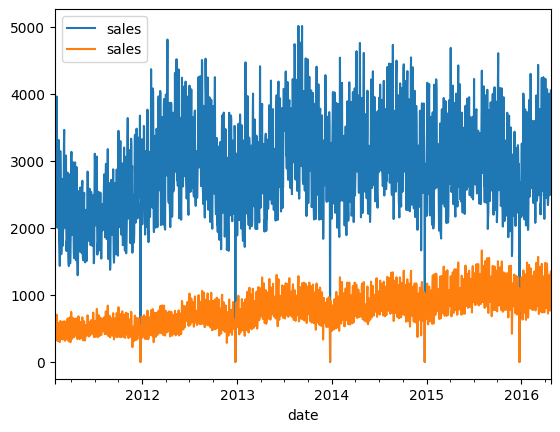

In [25]:
fig, ax = plt.subplots()
y.loc["CA_1-FOODS"].plot.line(ax=ax)
y.loc["CA_1-HOUSEHOLD"].plot.line(ax=ax)
fig.show()


- The window summarizer does not adjust (scale) the values within each window.
- Regressors like tree-based models may overly depend on these levels, and thus fail to capture generalizable patterns linking past and future values.
- Scaling or detrending the time series before applying the summarizer can help mitigate these issues.


**Potential solutions**

To solve this, we can adopt some approaches:

1. Detrending the timeseries
2. Differencing the timeseries
3. Scaling the timeseries.

**Detrending**

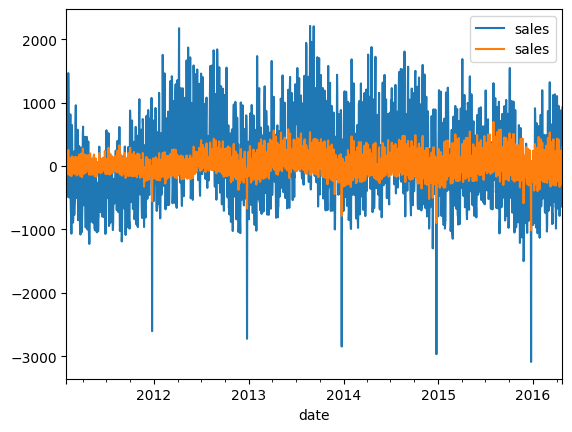

In [26]:
from sktime.transformations.series.detrend import Detrender
y_detrended = Detrender().fit_transform(y)
fig, ax = plt.subplots()
y_detrended.loc["CA_1-FOODS"].plot.line(ax=ax)
y_detrended.loc["CA_1-HOUSEHOLD"].plot.line(ax=ax)
fig.show()

**Differencing** 

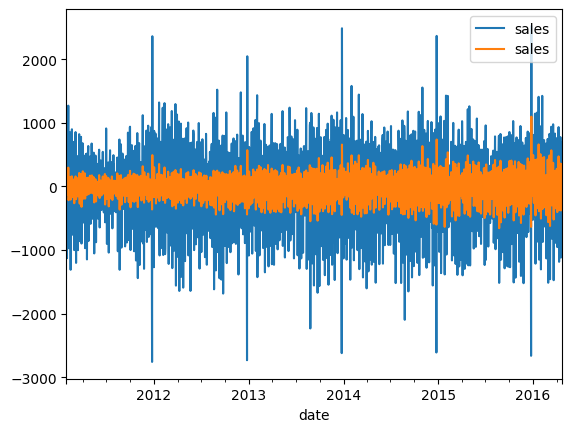

In [27]:
from sktime.transformations.series.difference import Differencer
y_differenced = Differencer().fit_transform(y)
fig, ax = plt.subplots()
y_differenced.loc["CA_1-FOODS"].plot.line(ax=ax)
y_differenced.loc["CA_1-HOUSEHOLD"].plot.line(ax=ax)
fig.show()

**Scaling**

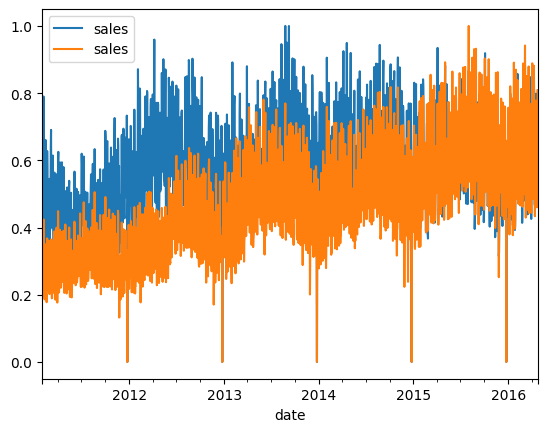

In [28]:
from sklearn.preprocessing import MinMaxScaler
from sktime.transformations.series.adapt import TabularToSeriesAdaptor

scaler = TabularToSeriesAdaptor(
    MinMaxScaler()
)
y_scaled = scaler.fit_transform(y)

# --

fig, ax = plt.subplots()
y_scaled.loc["CA_1-FOODS"].plot.line(ax=ax)
y_scaled.loc["CA_1-HOUSEHOLD"].plot.line(ax=ax)
fig.show()

#### Reduction global forecaster

Now, let's see how to use `make_reduction` to convert a regressor to a forecaster. We will use a simple linear regression model, but you can use any regressor you want.

In [29]:
# Import gradient boosting
from sklearn.ensemble import GradientBoostingRegressor

global_forecaster = make_reduction(
    GradientBoostingRegressor(),
    transformers=[window_summarizer],
    window_length=None,
    strategy="recursive",
    pooling="global",
)

detrended_global_forecaster = (
    scaler * global_forecaster
)
detrended_global_forecaster


TransformedTargetForecaster(steps=[TabularToSeriesAdaptor(transformer=MinMaxScaler()),
                                   RecursiveTabularRegressionForecaster(estimator=GradientBoostingRegressor(),
                                                                        pooling='global',
                                                                        transformers=[WindowSummarizer(lag_feature={'lag': [1,
                                                                                                                            2,
                                                                                                                            3,
                                                                                                                            4,
                                                                                                                            5,
                                                                                                                            6,
                                                                                                                            7,
                                                                                                                            8,
                                                                                                                            9,
                                                                                                                            10,
                                                                                                                            11,
                                                                                                                            12,
                                                                                                                            13,
                                                                                                                            14,
                                                                                                                            15,
                                                                                                                            16,
                                                                                                                            17,
                                                                                                                            18,
                                                                                                                            19,
                                                                                                                            20,
                                                                                                                            21,
                                                                                                                            22,
                                                                                                                            23,
                                                                                                                            24,
                                                                                                                            25,
                                                                                                                            26,
                                                                                                                            27,
                                                                                                                            28,
                                                                                                                            29,
         

In [30]:

detrended_global_forecaster.fit(y=y_train, fh=fh)
global_forecaster.fit(y=y_train, fh=fh)
# Predict
y_pred_detrended_global = detrended_global_forecaster.predict(fh=fh)
y_pred_global = global_forecaster.predict(fh=fh)

(<Figure size 1600x400 with 1 Axes>, <Axes: ylabel='sales'>)

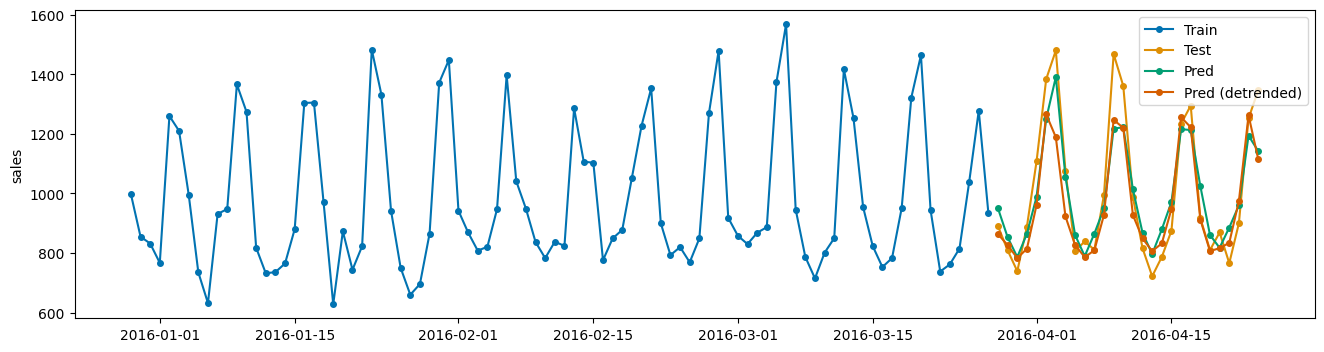

In [31]:
selected_series = "CA_1-HOUSEHOLD"
plot_series(
    y_train.loc[selected_series].iloc[-90:],
    y_test.loc[selected_series],
    y_pred_global.loc[selected_series],
    y_pred_detrended_global.loc[selected_series],
    labels=["Train", "Test", "Pred", "Pred (detrended)"],
)

#### Clustering + Global Forecasting

<img src="imgs/adicv.png" alt="ADICV" style="width:500px;">

In [32]:
from sktime.transformations.series.adi_cv import ADICVTransformer


categories = ADICVTransformer(["class"]).fit_transform(y_train)
counts = categories['class'].value_counts()
counts

class
smooth    30
Name: count, dtype: int64

In [33]:
from sktime.forecasting.compose import GroupbyCategoryForecaster
from sktime.forecasting.croston import Croston

groupby_category_forecaster = GroupbyCategoryForecaster(
    { "smooth" : detrended_global_forecaster,
     "erratic" : detrended_global_forecaster,
     "lumpy" : detrended_global_forecaster,
     "intermittent" : Croston(),
     },
    transformer=ADICVTransformer(["class"]),
)

groupby_category_forecaster.fit(y_train, fh=fh)
groupby_category_forecaster

GroupbyCategoryForecaster(forecasters={'erratic': TransformedTargetForecaster(steps=[TabularToSeriesAdaptor(transformer=MinMaxScaler()),
                                                                                     RecursiveTabularRegressionForecaster(estimator=GradientBoostingRegressor(),
                                                                                                                          pooling='global',
                                                                                                                          transformers=[WindowSummarizer(lag_feature={'lag': [1,
                                                                                                                                                                              2,
                                                                                                                                                                              3,
                                                                                                                                                                              4,
                                                                                                                                                                              5,
                                                                                                                                                                              6,
                                                                                                                                                                              7,
                                                                                                                                                                              8,
                                                                                                                                                                              9,
                                                                                                                                                                              10,
                                                                                                                                                                              11,
                                                                                                                                                                              12,
                                                                                                                                                                              13,
                                                                                                                                                                              14,
                                                                                                                                                                              15,
                                                                                                                                                                              16,
                                                                                                                                                                              17,
                                                                                                                                                                              18,
                                                                                                                                                                              19,
                                                                                                                                                                              20,
           

In [34]:
y_pred_groupby = groupby_category_forecaster.predict(fh=fh)
y_pred_groupby

sales
store_category date                   
CA_1-FOODS     2016-03-28  2769.324823
               2016-03-29  2576.617717
               2016-03-30  2476.091368
               2016-03-31  2526.014724
               2016-04-01  2971.329153
...                                ...
WI_3-HOUSEHOLD 2016-04-20   608.439934
               2016-04-21   627.871981
               2016-04-22   810.347601
               2016-04-23  1021.222692
               2016-04-24   956.054464

[840 rows x 1 columns]

### Metrics for panel data

Use `multilevel` parameter.

* If ``'uniform_average_time'``,
    metric is applied to all data, ignoring level index.
* If ``'uniform_average'`` (default),
    errors are mean-averaged across levels.
* If ``'raw_values'``,
    does not average errors across levels, hierarchy is retained.

In [35]:
from sktime.performance_metrics.forecasting import MeanAbsolutePercentageError

metric = MeanAbsolutePercentageError(multilevel="uniform_average_time")

metric(y_test, y_pred)

0.1080672896193659

In [36]:
MeanAbsolutePercentageError(multilevel="uniform_average")(
    y_test, y_pred
)

0.1080672896193659

In [37]:
MeanAbsolutePercentageError(multilevel="raw_values")(y_test, y_pred)

,MeanAbsolutePercentageError
CA_1-FOODS,0.075497
CA_1-HOBBIES,0.139117
CA_1-HOUSEHOLD,0.063010
CA_2-FOODS,0.057170
CA_2-HOBBIES,0.133175
CA_2-HOUSEHOLD,0.108036
CA_3-FOODS,0.118568
CA_3-HOBBIES,0.092009
CA_3-HOUSEHOLD,0.061770
CA_4-FOODS,0.069288


In [38]:
from sktime.forecasting.compose import ForecastByLevel


forecaster_local = ForecastByLevel(
    global_forecaster,
    groupby="local"
)

forecasting_pipeline_local = (
    scaler * forecaster_local
)


forecasting_pipeline_local.fit(y=y_train)

y_pred_local = forecasting_pipeline_local.predict(fh=fh)

In [39]:
metric_per_series = MeanAbsolutePercentageError(
    multilevel="raw_values",
)

exp_error = metric_per_series(y_test, y_pred, y_train=y_train)
# Global forecaster
global_error = metric_per_series(
    y_test, y_pred_global.set_index(y_test.index), y_train=y_train
)
# Detrended global forecaster
detrend_global_error = metric_per_series(
    y_test, y_pred_detrended_global.set_index(y_test.index), y_train=y_train
)
# Groupby global forecaster
global_groupby_error = metric_per_series(
    y_test, y_pred_groupby.set_index(y_test.index), y_train=y_train
)
local_error = metric_per_series(
    y_test, y_pred_local.set_index(y_test.index), y_train=y_train
)


# Join and concatenate errors
errors = (
    exp_error.rename(columns={"MeanAbsolutePercentageError": "Exp Smooth."})
    .join(
        global_error.rename(columns={"MeanAbsolutePercentageError": "Global GB"}),
    )
    .join(
        detrend_global_error.rename(
            columns={"MeanAbsolutePercentageError": "Detrended Global GB"}
        ),
    )
    .join(
        global_groupby_error.rename(
            columns={"MeanAbsolutePercentageError": "Groupby Global GB"}
        ),
    )
    .join(
        local_error.rename(columns={"MeanAbsolutePercentageError": "Local GB"}),
    )
)


errors = pd.concat(
    [
        errors,
        errors.mean().to_frame("Mean").T,
    ]
)

errors

,Exp Smooth.,Global GB,Detrended Global GB,Groupby Global GB,Local GB
CA_1-FOODS,0.075497,0.057254,0.060274,0.060274,0.048186
CA_1-HOBBIES,0.139117,0.153698,0.152869,0.152869,0.139299
CA_1-HOUSEHOLD,0.063010,0.077302,0.072065,0.072065,0.067770
CA_2-FOODS,0.057170,0.101022,0.110330,0.110330,0.124187
CA_2-HOBBIES,0.133175,0.141877,0.152585,0.152585,0.139011
CA_2-HOUSEHOLD,0.108036,0.126759,0.128640,0.128640,0.134250
CA_3-FOODS,0.118568,0.087225,0.072911,0.072911,0.060370
CA_3-HOBBIES,0.092009,0.129814,0.107049,0.107049,0.111993
CA_3-HOUSEHOLD,0.061770,0.068092,0.057867,0.057867,0.071955
CA_4-FOODS,0.069288,0.056146,0.047396,0.047396,0.053234



#### Global forecasting: summary of best practices

There are some evidences of good practices with global models:

* Scale Normalization as Preprocessing: in general, it is good to scale the series, but for certain problems scale is a crucial information (e.g. series with upper and lower bounds) [1]

* Window size ("Memory"): in general, global models can use larger memories than their local pairs.

* Clustering before fitting: 
    * it improves performance [1,3].
    * however, using a single global model without clustering and creating features related to the timeseries (such as frequency, volatility, etc) achieves even better results


---


## Hierarchical forecasting


<p align="center">
    <img src="imgs/m5_hierarchy.png" alt="Hierarchical Structure">
</p>

* **Opportunities**:
    * we can have a **large number of series**, and possibly use **global forecasting methods** to leverage the information across all series.
    * use the known **hierarchical structure** to improve our forecasts.  
* **Challenges**:
    * We need to respect the **aggregation constraints**, and the forecasts at the bottom level should be **coherent** with the forecasts at the upper levels. 


### Data structure for Hierarchical forecasting & Motivation

In [40]:
y = data.groupby(level=["state_id", "store_id", "cat_id", "date"])[["sales"]].sum()
y

/var/folders/_2/9y4tsvdd2n3gqjgd2zmlr1km0000gn/T/ipykernel_5256/1991413475.py:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  y = data.groupby(level=["state_id", "store_id", "cat_id", "date"])[["sales"]].sum()


sales
state_id store_id cat_id    date             
CA       CA_1     FOODS     2011-01-29   3239
                            2011-01-30   3137
                            2011-01-31   2008
                            2011-02-01   2258
                            2011-02-02   2032
...                                       ...
WI       WI_3     HOUSEHOLD 2016-04-20    683
                            2016-04-21    715
                            2016-04-22    867
                            2016-04-23   1033
                            2016-04-24    967

[172170 rows x 1 columns]

In [41]:
# Keep only series that do not have only 0s
y = y[(y == 0).groupby(level=[0,1,2]).transform('mean') != 1].dropna()
y

/var/folders/_2/9y4tsvdd2n3gqjgd2zmlr1km0000gn/T/ipykernel_5256/3039031584.py:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  y = y[(y == 0).groupby(level=[0,1,2]).transform('mean') != 1].dropna()


sales
state_id store_id cat_id    date              
CA       CA_1     FOODS     2011-01-29  3239.0
                            2011-01-30  3137.0
                            2011-01-31  2008.0
                            2011-02-01  2258.0
                            2011-02-02  2032.0
...                                        ...
WI       WI_3     HOUSEHOLD 2016-04-20   683.0
                            2016-04-21   715.0
                            2016-04-22   867.0
                            2016-04-23  1033.0
                            2016-04-24   967.0

[57390 rows x 1 columns]

In [42]:
y.index.droplevel(-1).unique()

MultiIndex([('CA', 'CA_1',     'FOODS'),
            ('CA', 'CA_1',   'HOBBIES'),
            ('CA', 'CA_1', 'HOUSEHOLD'),
            ('CA', 'CA_2',     'FOODS'),
            ('CA', 'CA_2',   'HOBBIES'),
            ('CA', 'CA_2', 'HOUSEHOLD'),
            ('CA', 'CA_3',     'FOODS'),
            ('CA', 'CA_3',   'HOBBIES'),
            ('CA', 'CA_3', 'HOUSEHOLD'),
            ('CA', 'CA_4',     'FOODS'),
            ('CA', 'CA_4',   'HOBBIES'),
            ('CA', 'CA_4', 'HOUSEHOLD'),
            ('TX', 'TX_1',     'FOODS'),
            ('TX', 'TX_1',   'HOBBIES'),
            ('TX', 'TX_1', 'HOUSEHOLD'),
            ('TX', 'TX_2',     'FOODS'),
            ('TX', 'TX_2',   'HOBBIES'),
            ('TX', 'TX_2', 'HOUSEHOLD'),
            ('TX', 'TX_3',     'FOODS'),
            ('TX', 'TX_3',   'HOBBIES'),
            ('TX', 'TX_3', 'HOUSEHOLD'),
            ('WI', 'WI_1',     'FOODS'),
            ('WI', 'WI_1',   'HOBBIES'),
            ('WI', 'WI_1', 'HOUSEHOLD'),
            ('WI

We use `Aggregator` to add missing totals to the dataset

In [43]:
from sktime.transformations.hierarchical.aggregate import Aggregator

y = Aggregator().fit_transform(y)
y

/Users/felipeangelim/Workspace/forecasting-course/.venv/lib/python3.11/site-packages/sktime/transformations/hierarchical/aggregate.py:121: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  out = X.groupby(level=indx_grouper).sum()
/Users/felipeangelim/Workspace/forecasting-course/.venv/lib/python3.11/site-packages/sktime/transformations/hierarchical/aggregate.py:121: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  out = X.groupby(level=indx_grouper).sum()


sales
state_id store_id cat_id  date               
CA       CA_1     FOODS   2011-01-29   3239.0
                          2011-01-30   3137.0
                          2011-01-31   2008.0
                          2011-02-01   2258.0
                          2011-02-02   2032.0
...                                       ...
__total  __total  __total 2016-04-20  35343.0
                          2016-04-21  35033.0
                          2016-04-22  40517.0
                          2016-04-23  48962.0
                          2016-04-24  49795.0

[84172 rows x 1 columns]

In [44]:
y.index.droplevel(-1).unique()

MultiIndex([(     'CA',    'CA_1',     'FOODS'),
            (     'CA',    'CA_1',   'HOBBIES'),
            (     'CA',    'CA_1', 'HOUSEHOLD'),
            (     'CA',    'CA_1',   '__total'),
            (     'CA',    'CA_2',     'FOODS'),
            (     'CA',    'CA_2',   'HOBBIES'),
            (     'CA',    'CA_2', 'HOUSEHOLD'),
            (     'CA',    'CA_2',   '__total'),
            (     'CA',    'CA_3',     'FOODS'),
            (     'CA',    'CA_3',   'HOBBIES'),
            (     'CA',    'CA_3', 'HOUSEHOLD'),
            (     'CA',    'CA_3',   '__total'),
            (     'CA',    'CA_4',     'FOODS'),
            (     'CA',    'CA_4',   'HOBBIES'),
            (     'CA',    'CA_4', 'HOUSEHOLD'),
            (     'CA',    'CA_4',   '__total'),
            (     'CA', '__total',   '__total'),
            (     'TX',    'TX_1',     'FOODS'),
            (     'TX',    'TX_1',   'HOBBIES'),
            (     'TX',    'TX_1', 'HOUSEHOLD'),
            (     'T

Having `__total` marked for a level means that this series is the sum of all series below. For example, `(CA, CA_1, __total, __total)` means that the index corresponds to the total for store CA_1, in the state of California.

In [45]:

# Splitting the data
from sktime.forecasting.model_selection import temporal_train_test_split

y_train, y_test = temporal_train_test_split(y, test_size=28)
fh = y_test.index.get_level_values(-1).unique()


In [46]:
from sktime.forecasting.ets import AutoETS
forecaster = AutoETS(auto=True, sp=7)
forecaster.fit(y_train)

y_pred = forecaster.predict(fh=fh)
y_pred

sales
state_id store_id cat_id  date                    
CA       CA_1     FOODS   2016-03-28   2839.066108
                          2016-03-29   2574.807029
                          2016-03-30   2559.173752
                          2016-03-31   2594.027865
                          2016-04-01   3009.269940
...                                            ...
__total  __total  __total 2016-04-20  36094.646978
                          2016-04-21  36419.522368
                          2016-04-22  41260.088196
                          2016-04-23  49782.021823
                          2016-04-24  49301.874039

[1232 rows x 1 columns]

In [47]:
y_pred - Aggregator().fit_transform(y_pred)

sales
state_id store_id cat_id  date                   
CA       CA_1     FOODS   2016-03-28     0.000000
                          2016-03-29     0.000000
                          2016-03-30     0.000000
                          2016-03-31     0.000000
                          2016-04-01     0.000000
...                                           ...
__total  __total  __total 2016-04-20  -306.752350
                          2016-04-21  -563.304147
                          2016-04-22  1123.161271
                          2016-04-23  -552.195206
                          2016-04-24   -79.362130

[1232 rows x 1 columns]


### Hierarchical forecasting methods

#### Key concepts


![Hierarchical reconciliation](imgs/hierarchical_reconciled_vs_not.png)

* **Coherent forecasts**: forecasts that respect the aggregation constraints. For example, if we forecast the sales for each product, the sum of the forecasts should be equal to the forecast for the department, and so on.
* **Base forecasts**: forecasts of the timeseries that do not necessarily respect the aggregation constraints. Denoted by $\tilde{y}$.
* **Reconciliation**: the process of adjusting base forecasts to make them coherent. 
* **Reconciled forecasts**: coherent forecasts obtained after reconciliation. Denoted by $\hat{y}$.
* **Bottom levels**: the most granular levels of the hierarchy. We use $n_b$ to denote the number of bottom levels. Note that if we forecast only the bottom levels, their aggregation will be coherent by construction.

The number of total timeseries is denoted by $n$.


#### Hierarchical methods

**Bottom-up**:

<p align="center">
    <img src="imgs/hierarchical_bottomup.png" alt="Bottom-up Reconciliation" style="width:400px;">
</p>

* We use the base forecasts of the bottom levels, and aggregate them to obtain the reconciled forecasts for the upper levels.
* This approach can benefit from the fact that some patterns may be easier to learn from the most granular data; however, it can also suffer from noise.

**Top-down**:

<p align="center">
    <img src="imgs/hierarchical_topdown.png" alt="Bottom-up Reconciliation" style="width:400px;">
</p>

* The top-down forecasting consists of using the original base forecast for the total level, and using some strategy to forecast the share of bottom levels. 
* This approach can benefit from the fact that the total level is usually more stable, and possibly easier to forecast.

* **Forecasting the shares**: we first transform the bottom series to shares with respect to the total( $share_i(t) =\tilde{y}_i(t) / \tilde{y}_{tot}(t)$), and then forecast these shares. The reconciled forecasts are obtained by multiplication.

* **Forecast proportions**: we compute the shares using base forecasts. 

<p align="center">
    <img src="imgs/hierarchical_td_fcst.png" alt="Top-down Reconciliation" style="width:800px;">
</p>

**Full-hierarchy reconciliation**

* **OLS** : project the base forecasts into the reconciliation space. 
* **Weighted OLS**: project all base forecasts into the reconciliation space, but with different weights.
* **Minimum trace (MinT)**: use the error covariance matrix to find the optimal reconciled forecasts. Called "optimal".




We can also seek other projections, such as non-orthogonal projections, such that the forecasts with less error are more preserved. This is the idea behind the optimal reconciliation methods, such as the MinT method. 


### Reconciliation methods with sktime


#### Reconciliations that do not use error correlations

As we saw right above, there are some reconciliation methods that require the error correlations of the base forecasts. We  will start with the ones that do not require this information, and can be implemented using `Reconciler` class in sktime.

In [48]:
from sktime.transformations.hierarchical.reconcile import Reconciler

# Bottom-up
y_pred_bu = Reconciler("bu").fit_transform(y_pred)
# Forecast proportions
y_pred_td_fcst = Reconciler("td_fcst").fit_transform(y_pred)
# Ortogonal projections onto the coherent space
y_pred_ols = Reconciler("ols").fit_transform(y_pred)
# Projection onto the coherent space, that assumes that
# The WLS assumes that the base  bottom-level forecast
# have uncorrelated and equal variances
y_pred_wls = Reconciler("wls_str").fit_transform(y_pred)

To check the coherence of the forecasts, we can verify the difference between the original samples and the bottom-up reconciliation. If they indeed are coherent, the difference should be zero.

In [49]:
y_pred_wls - Aggregator().fit_transform(y_pred_wls)

sales
state_id store_id cat_id  date                    
CA       CA_1     FOODS   2016-03-28  0.000000e+00
                          2016-03-29  0.000000e+00
                          2016-03-30  0.000000e+00
                          2016-03-31  0.000000e+00
                          2016-04-01  0.000000e+00
...                                            ...
__total  __total  __total 2016-04-20  7.275958e-12
                          2016-04-21  0.000000e+00
                          2016-04-22  1.455192e-11
                          2016-04-23  7.275958e-12
                          2016-04-24 -1.455192e-11

[1232 rows x 1 columns]

#### Reconciliations that use error correlations

The "optimal" methods, such as the MinT method, require the error correlations of the base forecasts. We can use the `ReconcilerForecaster` class to apply these methods. It wraps a base forecaster, and uses the error correlations to adjust the forecasts. 

In [50]:
from sktime.forecasting.reconcile import ReconcilerForecaster
from sktime.forecasting.ets import AutoETS
from sktime.forecasting.compose import FallbackForecaster
from sktime.transformations.series.augmenter import WhiteNoiseAugmenter

# Currently only works for models that can do out of sample predictions!
forecaster_mint = ReconcilerForecaster(
    forecaster=forecaster,
    method="mint_shrink",
)

forecaster_mint.fit(y_train)
y_pred_mint_shrink = forecaster_mint.predict(fh=fh)

#### There is no silver bullet

* Although the "optimal" methods are called as such, they do not always outperform the alternatives. * They are optimal if the error covariance matrix is correctly specified, but it is also estimated from the data and is prone to errors (especially when the number of series is large, and the number of samples is small). 
* Good news: the OLS approach (the ortogonal projection) **always** outperform the base forecasts in the mean squared error. 

In [51]:
forecasts = {
    "base": y_pred,
    "bu": y_pred_bu,
    "td_fcst": y_pred_td_fcst,
    "ols": y_pred_ols,
    "wls": y_pred_wls,
    "mint_shrink": y_pred_mint_shrink,
}

from sktime.performance_metrics.forecasting import MeanAbsoluteError

msse = MeanAbsoluteError(multilevel="uniform_average")

errors = {
    k : msse(y_test, v, y_train=y_train) for k,v in forecasts.items()
}

pd.DataFrame(errors, index=["MSSE"]).T

,MSSE
base,304.267413
bu,307.990116
td_fcst,298.882732
ols,301.436723
wls,300.605679
mint_shrink,324.604791


## Summary

- Global forecasting and local forecasting
- Clustering + Global forecasting
- Hierarchical forecasting


Current limitations in sktime (are being addressed for a nearby release!):

- Zero-shot forecasting
- New reconciliation methods, and pre-computed error covariance matrix.

# References
----------
[1] Montero-Manso, Pablo, and Rob J. Hyndman. "Principles and algorithms for forecasting groups of time series: Locality and globality." International Journal of Forecasting 37.4 (2021): 
1632-1653.

[2] Makridakis, Spyros, Evangelos Spiliotis, and Vassilios Assimakopoulos. "M5 accuracy competition: Results, findings, and conclusions." International Journal of Forecasting 38.4 (2022): 1346-1364.

[3] Semenoglou, Artemios-Anargyros, et al. "Investigating the accuracy of cross-learning time series forecasting methods." International Journal of Forecasting 37.3 (2021): 1072-1084.

[4] Zhang, Bohan, et al. "Optimal reconciliation with immutable forecasts." European Journal of Operational Research 308.2 (2023): 650-660.

[5] Wickramasuriya, S. L., Athanasopoulos, G. and Hyndman, R. J. (2019), ‘Optimal forecast reconciliation for hierarchical and grouped time series through trace minimization’, Journal of the American Statistical Association 114(526), 804–819.

[6] Wickramasuriya, S. L., Turlach, B. A. and Hyndman, R. J. (2020), ‘Optimal non-negative forecast reconciliation’, Statistics and Computing 30(5), 1167–1182.

[7] Spiliotis, Evangelos, et al. "Hierarchical forecast reconciliation with machine learning." Applied Soft Computing 112 (2021): 107756.

[8] Burba, Davide, and Trista Chen. "A trainable reconciliation method for hierarchical time-series." arXiv preprint arXiv:2101.01329 (2021).

[9] Hyndman, Rob J., et al. "Optimal combination forecasts for hierarchical time series." Computational statistics & data analysis 55.9 (2011): 2579-2589.

[10] Kourentzes, Nikolaos, and George Athanasopoulos. "Cross-temporal coherent forecasts for Australian tourism." Annals of Tourism Research 75 (2019): 393-409.

[11] Di Fonzo, Tommaso, and Daniele Girolimetto. "Cross-temporal forecast reconciliation: Optimal combination method and heuristic alternatives." International Journal of Forecasting 39.1 (2023): 39-57.

[12] Athanasopoulos, George, et al. "Forecast reconciliation: A review." International Journal of Forecasting 40.2 (2024): 430-456.
